# Project: Wrangling and Analyze Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import tweepy
from tweepy import OAuthHandler
import json
import seaborn as sb
from timeit import default_timer as timer
from numpy import nan

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [2]:
# Download twitter-archive-enhanced.csv
twitter_archive_url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/59a4e958_twitter-archive-enhanced/twitter-archive-enhanced.csv'
response = requests.get(twitter_archive_url)
response

<Response [200]>

In [3]:
# Save url response to twitter-archive-enhanced.csv file
file_name = twitter_archive_url.split('/')[-1]
with open(file_name, mode = 'wb') as file:
      file.write(response.content)

In [4]:
# Load and read the WeRateDogs Twitter archive
df_twitter_archive_enhanced = pd.read_csv('twitter-archive-enhanced.csv')
df_twitter_archive_enhanced.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [5]:
tweet_ids = df_twitter_archive_enhanced.tweet_id.values
len(tweet_ids)

2356

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [6]:
# Download image_predictions.tsv
predictions_url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(predictions_url)
response

<Response [200]>

In [7]:
# Save url response to image_predictions.tsv file
file_name = predictions_url.split('/')[-1]
with open(file_name, mode = 'wb') as file:
      file.write(response.content)

In [8]:
# Load image-predictions.tsv
df_image_predictions = pd.read_csv('image-predictions.tsv', sep='\t')
df_image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [9]:
# Twitter API 
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

In [ ]:
# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()

# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except Exception as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

##### Note: I have downloaded the data from the API and stored the result in tweet_json.txt. However, for the following steps I have used the provided tweet-json.txt to ensure accurate results. Due to the removed credentials, I have manually uploaded both files.

In [10]:
# Load downloaded JSON data for each tweet
tweet_json_data = []
with open('tweet-json.txt') as file:
    for i in file:
        json_data = json.loads(i)
        #print(json_data)
        tweet_id = json_data['id']
        in_reply_to_status_id = json_data['in_reply_to_status_id']
        in_reply_to_user_id = json_data['in_reply_to_user_id'],
        time_stamp = json_data['created_at']
        source = json_data['source']
        text = json_data['full_text']
        retweeted = json_data['retweeted']
        user_id = json_data['user']['id']
        user_name = json_data['user']['name']
        user_location = json_data['user']['location']
        user_description = json_data['user']['description']
        followers_count = json_data['user']['followers_count']
        friends_count = json_data['user']['friends_count']
        retweet_count = json_data['retweet_count']
        listed_count = json_data['user']['listed_count']
        favorite_count = json_data['favorite_count']
        tweet_json_data.append({'tweet_id': tweet_id,
                             'in_reply_to_status_id': in_reply_to_status_id,
                             'in_reply_to_user_id': in_reply_to_user_id,
                             'timestamp': time_stamp,
                             'source': source,
                             'text': text,
                             'retweeted': retweeted,
                             'user_id': user_id,
                             'user_name': user_name,
                             'user_location': user_location,
                             'user_description': user_description,
                             'followers_count': followers_count,
                             'friends_count': friends_count,
                             'retweet_count': retweet_count,
                             'listed_count': listed_count,
                             'favorite_count': favorite_count})

In [11]:
# Store parsed data in dataframe
df_tweet_json = pd.DataFrame(tweet_json_data, columns = ['tweet_id','in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp', 'source', 'text','retweeted', 'user_id','user_name','user_location','user_description','followers_count','friends_count','retweet_count','listed_count','favorite_count'])
df_tweet_json.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted,user_id,user_name,user_location,user_description,followers_count,friends_count,retweet_count,listed_count,favorite_count
0,892420643555336193,NaN,"(None,)",Tue Aug 01 16:23:56 +0000 2017,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,False,4196983835,WeRateDogs™ (author),"DM YOUR DOGS, WE WILL RATE",#1 Source for Professional Dog Ratings | STORE...,3200889,104,8853,2784,39467
1,892177421306343426,NaN,"(None,)",Tue Aug 01 00:17:27 +0000 2017,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,False,4196983835,WeRateDogs™ (author),"DM YOUR DOGS, WE WILL RATE",#1 Source for Professional Dog Ratings | STORE...,3200889,104,6514,2784,33819
2,891815181378084864,NaN,"(None,)",Mon Jul 31 00:18:03 +0000 2017,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,False,4196983835,WeRateDogs™ (author),"DM YOUR DOGS, WE WILL RATE",#1 Source for Professional Dog Ratings | STORE...,3200889,104,4328,2784,25461
3,891689557279858688,NaN,"(None,)",Sun Jul 30 15:58:51 +0000 2017,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,False,4196983835,WeRateDogs™ (author),"DM YOUR DOGS, WE WILL RATE",#1 Source for Professional Dog Ratings | STORE...,3200889,104,8964,2784,42908
4,891327558926688256,NaN,"(None,)",Sat Jul 29 16:00:24 +0000 2017,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,False,4196983835,WeRateDogs™ (author),"DM YOUR DOGS, WE WILL RATE",#1 Source for Professional Dog Ratings | STORE...,3200889,104,9774,2784,41048


In [12]:
# Export available data for visual assessment
df_tweet_json.to_csv('twitter_api.csv', decimal='.', sep=',', encoding='utf-8', index=False)

## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



### Twitter Archive Enhanced Data

In [13]:
# Visual assessment
df_twitter_archive_enhanced

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [14]:
# Assess datatypes
df_twitter_archive_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [15]:
# Assess null values
df_twitter_archive_enhanced.isnull().sum().sort_values(ascending=False)

in_reply_to_status_id         2278
in_reply_to_user_id           2278
retweeted_status_timestamp    2175
retweeted_status_user_id      2175
retweeted_status_id           2175
expanded_urls                   59
timestamp                        0
source                           0
text                             0
puppo                            0
pupper                           0
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
tweet_id                         0
dtype: int64

In [16]:
# Asses number of unique values
df_twitter_archive_enhanced.nunique().sort_values(ascending=False)

tweet_id                      2356
timestamp                     2356
text                          2356
expanded_urls                 2218
name                           957
retweeted_status_id            181
retweeted_status_timestamp     181
in_reply_to_status_id           77
rating_numerator                40
in_reply_to_user_id             31
retweeted_status_user_id        25
rating_denominator              18
source                           4
pupper                           2
doggo                            2
floofer                          2
puppo                            2
dtype: int64

In [17]:
# Assess
df_twitter_archive_enhanced.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [18]:
# Assess different name values
df_twitter_archive_enhanced['name'].value_counts()

None         745
a             55
Charlie       12
Cooper        11
Lucy          11
Oliver        11
Penny         10
Tucker        10
Lola          10
Winston        9
Bo             9
Sadie          8
the            8
Daisy          7
an             7
Toby           7
Bailey         7
Buddy          7
Jax            6
Leo            6
Koda           6
Oscar          6
Dave           6
Bella          6
Jack           6
Stanley        6
Scout          6
Rusty          6
Milo           6
very           5
            ... 
old            1
Joshwa         1
Carper         1
Kathmandu      1
Eazy           1
Banjo          1
Diogi          1
Lambeau        1
Ricky          1
Bruiser        1
Teddy          1
Eevee          1
Corey          1
Remus          1
Bubba          1
Tayzie         1
Batdog         1
Tedders        1
Godi           1
Jaspers        1
Hubertson      1
Ralphie        1
Fwed           1
Mo             1
Anthony        1
Blu            1
Sprinkles      1
Travis        

### Twitter API Data

In [19]:
# Visual assessment
df_tweet_json

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted,user_id,user_name,user_location,user_description,followers_count,friends_count,retweet_count,listed_count,favorite_count
0,892420643555336193,NaN,"(None,)",Tue Aug 01 16:23:56 +0000 2017,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,False,4196983835,WeRateDogs™ (author),"DM YOUR DOGS, WE WILL RATE",#1 Source for Professional Dog Ratings | STORE...,3200889,104,8853,2784,39467
1,892177421306343426,NaN,"(None,)",Tue Aug 01 00:17:27 +0000 2017,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,False,4196983835,WeRateDogs™ (author),"DM YOUR DOGS, WE WILL RATE",#1 Source for Professional Dog Ratings | STORE...,3200889,104,6514,2784,33819
2,891815181378084864,NaN,"(None,)",Mon Jul 31 00:18:03 +0000 2017,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,False,4196983835,WeRateDogs™ (author),"DM YOUR DOGS, WE WILL RATE",#1 Source for Professional Dog Ratings | STORE...,3200889,104,4328,2784,25461
3,891689557279858688,NaN,"(None,)",Sun Jul 30 15:58:51 +0000 2017,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,False,4196983835,WeRateDogs™ (author),"DM YOUR DOGS, WE WILL RATE",#1 Source for Professional Dog Ratings | STORE...,3200889,104,8964,2784,42908
4,891327558926688256,NaN,"(None,)",Sat Jul 29 16:00:24 +0000 2017,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,False,4196983835,WeRateDogs™ (author),"DM YOUR DOGS, WE WILL RATE",#1 Source for Professional Dog Ratings | STORE...,3200889,104,9774,2784,41048
5,891087950875897856,NaN,"(None,)",Sat Jul 29 00:08:17 +0000 2017,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,False,4196983835,WeRateDogs™ (author),"DM YOUR DOGS, WE WILL RATE",#1 Source for Professional Dog Ratings | STORE...,3200889,104,3261,2784,20562
6,890971913173991426,NaN,"(None,)",Fri Jul 28 16:27:12 +0000 2017,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,False,4196983835,WeRateDogs™ (author),"DM YOUR DOGS, WE WILL RATE",#1 Source for Professional Dog Ratings | STORE...,3200889,104,2158,2784,12041
7,890729181411237888,NaN,"(None,)",Fri Jul 28 00:22:40 +0000 2017,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,False,4196983835,WeRateDogs™ (author),"DM YOUR DOGS, WE WILL RATE",#1 Source for Professional Dog Ratings | STORE...,3200889,104,16716,2784,56848
8,890609185150312448,NaN,"(None,)",Thu Jul 27 16:25:51 +0000 2017,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,False,4196983835,WeRateDogs™ (author),"DM YOUR DOGS, WE WILL RATE",#1 Source for Professional Dog Ratings | STORE...,3200889,104,4429,2784,28226
9,890240255349198849,NaN,"(None,)",Wed Jul 26 15:59:51 +0000 2017,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,False,4196983835,WeRateDogs™ (author),"DM YOUR DOGS, WE WILL RATE",#1 Source for Professional Dog Ratings | STORE...,3200889,104,7711,2784,32467


In [20]:
# Asses datatypes and number of rows
df_tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 16 columns):
tweet_id                 2354 non-null int64
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      2354 non-null object
timestamp                2354 non-null object
source                   2354 non-null object
text                     2354 non-null object
retweeted                2354 non-null bool
user_id                  2354 non-null int64
user_name                2354 non-null object
user_location            2354 non-null object
user_description         2354 non-null object
followers_count          2354 non-null int64
friends_count            2354 non-null int64
retweet_count            2354 non-null int64
listed_count             2354 non-null int64
favorite_count           2354 non-null int64
dtypes: bool(1), float64(1), int64(7), object(7)
memory usage: 278.2+ KB


In [21]:
# Asses null values
df_tweet_json.isnull().sum().sort_values(ascending=False)

in_reply_to_status_id    2276
favorite_count              0
listed_count                0
retweet_count               0
friends_count               0
followers_count             0
user_description            0
user_location               0
user_name                   0
user_id                     0
retweeted                   0
text                        0
source                      0
timestamp                   0
in_reply_to_user_id         0
tweet_id                    0
dtype: int64

In [22]:
# Asses unique values
df_tweet_json.nunique().sort_values(ascending=False)

text                     2354
timestamp                2354
tweet_id                 2354
favorite_count           2007
retweet_count            1724
in_reply_to_status_id      77
followers_count            66
in_reply_to_user_id        32
listed_count               20
source                      4
friends_count               1
user_description            1
user_location               1
user_name                   1
user_id                     1
retweeted                   1
dtype: int64

In [23]:
df_tweet_json.describe()

,tweet_id,in_reply_to_status_id,user_id,followers_count,friends_count,retweet_count,listed_count,favorite_count
count,2.354000e+03,7.800000e+01,2.354000e+03,2.354000e+03,2354.0,2354.000000,2354.000000,2354.000000
mean,7.426978e+17,7.455079e+17,4.196984e+09,3.200942e+06,104.0,3164.797366,2799.480884,8080.968564
std,6.852812e+16,7.582492e+16,0.000000e+00,4.457302e+01,0.0,5284.770364,11.178223,11814.771334
min,6.660209e+17,6.658147e+17,4.196984e+09,3.200799e+06,104.0,0.000000,2724.000000,0.000000
25%,6.783975e+17,6.757419e+17,4.196984e+09,3.200898e+06,104.0,624.500000,2788.000000,1415.000000
50%,7.194596e+17,7.038708e+17,4.196984e+09,3.200945e+06,104.0,1473.500000,2803.000000,3603.500000
75%,7.993058e+17,8.257804e+17,4.196984e+09,3.200953e+06,104.0,3652.000000,2805.000000,10122.250000
max,8.924206e+17,8.862664e+17,4.196984e+09,3.201018e+06,104.0,79515.000000,2846.000000,132810.000000


### Image Predictions Data

In [24]:
# Visual Assessment
df_image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [25]:
# Assess datatypes
df_image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [26]:
# Assess null values
df_image_predictions.isnull().sum().sort_values(ascending=False)

p3_dog      0
p3_conf     0
p3          0
p2_dog      0
p2_conf     0
p2          0
p1_dog      0
p1_conf     0
p1          0
img_num     0
jpg_url     0
tweet_id    0
dtype: int64

In [27]:
# Assess unique values
df_image_predictions.nunique().sort_values(ascending=False)

tweet_id    2075
jpg_url     2009
p3_conf     2006
p1_conf     2006
p2_conf     2004
p3           408
p2           405
p1           378
img_num        4
p3_dog         2
p2_dog         2
p1_dog         2
dtype: int64

In [28]:
df_image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


<a id='issues'></a>
### Quality issues

##### `Twitter Archive Enhanced` table
1. <a href="#code1">issue: </a> timestamp & retweeted_status_timestamp are a string not a datetime
2. <a href="#code2">issue:</a> in_reply_to_status_id & in_reply_to_user_id are a float64 not a string 
3. <a href="#code3">issue: </a> doggo, floofer, pupper and puppo contain value 'None' instead of NaN
4. <a href="#code4">issue: </a> name contains incorrect values & misses names (i.e. lowercase words & 'None')
5. <a>issue: </a> missing values in in_reply_to_user_id, retweeted_status_timestamp,retweeted_status_id ***(can't clean)***


##### `Twitter API Data` table
6. <a href="#code6">issue: </a>timestamp is a string not a datetime
7. <a href="#code7">issue: </a>in_reply_to_status_id & in_reply_to_user_id are a float64 not a string

##### `Image Predictions Data` table
8. <a href="#code8">issue: </a>p1, p2, p3 columns contain "non-dogbreed" values
9. <a href="#code9">issue: </a>p1, p2, p3 contains empty values 

<a id='tidiness'></a>
### Tidiness issues

##### `Twitter Archive Enhanced` table
1. <a href="#tidiness1">tidiness: </a>doggo, floofer, pupper and puppo are object types but should be a category
2. <a href="#tidiness2">tidiness: </a>source values contain HTML tags

##### `Image Predictions Data` table
3. <a href="#tidiness3">tidiness: </a>Various dog breeds are lowercase
4. <a href="#tidiness4">tidiness: </a>Dog breeds contain lowercase characters
5. <a href="#tidiness5">tidiness: </a>Inconsistent values for p\*_conf columns

##### `Master Data` table
6. <a href="#tidiness6">tidiness: </a>Rename and remove (less relevant) columns
7. <a>tidiness: </a>retweeted_status_id, name, rating_numerator & rating_denominator data missing ***(can't clean)***

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [29]:
# Make copies of original pieces of data
df_twitter_archive_enhanced_clean = df_twitter_archive_enhanced.copy()
df_twitter_archive_enhanced_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [30]:
df_tweet_json_clean = df_tweet_json.copy()
df_tweet_json_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted,user_id,user_name,user_location,user_description,followers_count,friends_count,retweet_count,listed_count,favorite_count
0,892420643555336193,NaN,"(None,)",Tue Aug 01 16:23:56 +0000 2017,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,False,4196983835,WeRateDogs™ (author),"DM YOUR DOGS, WE WILL RATE",#1 Source for Professional Dog Ratings | STORE...,3200889,104,8853,2784,39467
1,892177421306343426,NaN,"(None,)",Tue Aug 01 00:17:27 +0000 2017,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,False,4196983835,WeRateDogs™ (author),"DM YOUR DOGS, WE WILL RATE",#1 Source for Professional Dog Ratings | STORE...,3200889,104,6514,2784,33819
2,891815181378084864,NaN,"(None,)",Mon Jul 31 00:18:03 +0000 2017,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,False,4196983835,WeRateDogs™ (author),"DM YOUR DOGS, WE WILL RATE",#1 Source for Professional Dog Ratings | STORE...,3200889,104,4328,2784,25461
3,891689557279858688,NaN,"(None,)",Sun Jul 30 15:58:51 +0000 2017,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,False,4196983835,WeRateDogs™ (author),"DM YOUR DOGS, WE WILL RATE",#1 Source for Professional Dog Ratings | STORE...,3200889,104,8964,2784,42908
4,891327558926688256,NaN,"(None,)",Sat Jul 29 16:00:24 +0000 2017,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,False,4196983835,WeRateDogs™ (author),"DM YOUR DOGS, WE WILL RATE",#1 Source for Professional Dog Ratings | STORE...,3200889,104,9774,2784,41048


In [31]:
df_image_predictions_clean = df_image_predictions.copy()
df_image_predictions_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


<a id='code1'></a>
### Issue #1: timestamp & retweeted_status_timestamp are a string not a datetime
<a href="#issues">Back to Issues</a>

#### Define: 
Change the 'timestamp' & 'retweeted_status_timestamp' columns to datetime datatype

#### Code

In [32]:
# convert datatype of timestamp column to datetime
df_twitter_archive_enhanced_clean['timestamp'] = pd.to_datetime(df_twitter_archive_enhanced_clean['timestamp'])

In [33]:
# convert datatype of retweeted_status_timestamp column to datetime
df_twitter_archive_enhanced_clean['retweeted_status_timestamp'] = pd.to_datetime(df_twitter_archive_enhanced_clean['retweeted_status_timestamp'])

#### Test

In [34]:
# Check if columns have datetime datatype assigned
print("timestamp is a datatype datetime: ",'\033[1m'  + str(pd.core.dtypes.common.is_datetime64_ns_dtype(df_twitter_archive_enhanced_clean['timestamp'])) + '\033[0m')
print("retweeted_status_timestamp is a datatype datetime: ",'\033[1m'  + str(pd.core.dtypes.common.is_datetime64_ns_dtype(df_twitter_archive_enhanced_clean['retweeted_status_timestamp'])) + '\033[0m')

timestamp is a datatype datetime:  True
retweeted_status_timestamp is a datatype datetime:  True


<a id='code2'></a>
### Issue #2: in_reply_to_status_id & in_reply_to_user_id are a float64 not a string
<a href="#issues">Back to Issues</a>

#### Define
Change the datatype of the 'in_reply_to_status_id' & 'in_reply_to_user_id' columns to an string datatype

#### Code

In [35]:
# Convert datatype of involved columns to string
df_twitter_archive_enhanced_clean['in_reply_to_status_id'] = df_twitter_archive_enhanced_clean['in_reply_to_status_id'].astype(str)
df_twitter_archive_enhanced_clean['in_reply_to_user_id'] = df_twitter_archive_enhanced_clean['in_reply_to_user_id'].astype(str)

#### Test

In [36]:
# Check if columns have string datatype assigned
assert pd.api.types.is_string_dtype(df_twitter_archive_enhanced_clean['in_reply_to_status_id'])
assert pd.api.types.is_string_dtype(df_twitter_archive_enhanced_clean['in_reply_to_user_id'])

<a id='code3'></a>
### Issue #3: doggo, floofer, pupper and puppo contain value 'None' instead of NaN
<a href="#issues">Back to Issues</a>

#### Define
Replace 'None' values in doggo, floofer, pupper and puppo columns with NaN

#### Code

In [37]:
# Replace 'None' with NaN
df_twitter_archive_enhanced_clean['doggo'] = np.where(df_twitter_archive_enhanced_clean['doggo'] == 'None', np.NaN, df_twitter_archive_enhanced_clean['doggo'])
df_twitter_archive_enhanced_clean['floofer'] = np.where(df_twitter_archive_enhanced_clean['floofer'] == 'None', np.NaN, df_twitter_archive_enhanced_clean['floofer'])
df_twitter_archive_enhanced_clean['pupper'] = np.where(df_twitter_archive_enhanced_clean['pupper'] == 'None', np.NaN, df_twitter_archive_enhanced_clean['pupper'])
df_twitter_archive_enhanced_clean['puppo'] = np.where(df_twitter_archive_enhanced_clean['puppo'] == 'None', np.NaN, df_twitter_archive_enhanced_clean['puppo'])

#### Test

In [38]:
# Test doggo
df_twitter_archive_enhanced_clean['doggo'].value_counts()

doggo    97
Name: doggo, dtype: int64

In [39]:
# Test floofer
df_twitter_archive_enhanced_clean['floofer'].value_counts()

floofer    10
Name: floofer, dtype: int64

In [40]:
# Test pupper
df_twitter_archive_enhanced_clean['pupper'].value_counts()

pupper    257
Name: pupper, dtype: int64

In [41]:
# Test puppo
df_twitter_archive_enhanced_clean['puppo'].value_counts()

puppo    30
Name: puppo, dtype: int64

<a id='code4'></a>
### Issue #4: name contains incorrect values & misses names (i.e. lowercase words & 'None')
<a href="#issues">Back to Issues</a>

#### Define
Remove incorrect lowercase names & 'None' name from 'name' column

#### Code

In [42]:
# Define: Remove incorrect 'lowercase' names from 'name' column
df_twitter_archive_enhanced_clean['name'] = np.where(df_twitter_archive_enhanced_clean['name'].str.islower().fillna(False), np.NaN, df_twitter_archive_enhanced_clean['name'])

In [43]:
# Define: Remove 'None' name from 'name' column
df_twitter_archive_enhanced_clean['name'] = np.where(df_twitter_archive_enhanced_clean['name'] == 'None', np.NaN, df_twitter_archive_enhanced_clean['name'])

#### Test

In [44]:
# Test: Check for lowercase names in 'name' column
df_twitter_archive_enhanced_clean[df_twitter_archive_enhanced_clean['name'].str.islower().fillna(False)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [45]:
# Test: Check for 'None' value in 'name' column
df_twitter_archive_enhanced_clean[df_twitter_archive_enhanced_clean['name'] == 'None']['name'].count()

0

<a id='code6'></a>
### Issue #6: timestamp is a string not a datetime¶
<a href="#issues">Back to Issues</a>

#### Define
Change the 'timestamp' column to datetime datatype

#### Code

In [46]:
# Convert timestamp column to datetime datatype
df_tweet_json_clean['timestamp'] = pd.to_datetime(df_tweet_json_clean['timestamp'])

#### Test

In [47]:
# Check if datatype of timestamp column is datetime
print("timestamp is a datatype datetime: ",'\033[1m'  + str(pd.core.dtypes.common.is_datetime64_ns_dtype(df_tweet_json_clean['timestamp'])) + '\033[0m')

timestamp is a datatype datetime:  True


<a id='code7'></a>
### Issue #7: in_reply_to_status_id & in_reply_to_user_id are a float64 not a string¶
<a href="#issues">Back to Issues</a>

#### Define
Change the datatype of the 'in_reply_to_status_id' & 'in_reply_to_user_id' columns to an object datatype

#### Code

In [48]:
# in_reply_to_status_id & in_reply_to_user_id are a float64 not a string
df_tweet_json['in_reply_to_status_id'] = df_tweet_json['in_reply_to_status_id'].astype(str)
df_tweet_json['in_reply_to_user_id'] = df_tweet_json['in_reply_to_user_id'].astype(str)

#### Test

In [49]:
# Check if columns have string datatype assigned
assert pd.api.types.is_string_dtype(df_tweet_json['in_reply_to_status_id'])
assert pd.api.types.is_string_dtype(df_tweet_json['in_reply_to_user_id'])

<a id='code8'></a>
### Issue #8: p1, p2, p3 columns contain non-dogbreed values
<a href="#issues">Back to Issues</a>

#### Define
Remove values from p1, p2 & p3 if the object is not identified as a dog. Also remove the attached p1_conf, p2_conf, p3_conf

#### Code

In [50]:
# Remove all value from p1 where p1_dog equals False
df_image_predictions_clean['p1'] = np.where((df_image_predictions_clean['p1_dog'] == False), '', df_image_predictions_clean['p1'])

In [51]:
# Remove all value from p1_conf where p1_dog equals False
df_image_predictions_clean['p1_conf'] = np.where((df_image_predictions_clean['p1_dog'] == False), nan, df_image_predictions_clean['p1_conf'])

In [52]:
# Remove all value from p2 where p2_dog equals False
df_image_predictions_clean['p2'] = np.where((df_image_predictions_clean['p2_dog'] == False), '', df_image_predictions_clean['p2'])

In [53]:
# Remove all value from p2_conf where p3_dog equals False
df_image_predictions_clean['p2_conf'] = np.where((df_image_predictions_clean['p2_dog'] == False), nan, df_image_predictions_clean['p2_conf'])

In [54]:
# Remove all value from p3 where p3_dog equals False
df_image_predictions_clean['p3'] = np.where((df_image_predictions_clean['p3_dog'] == False), '', df_image_predictions_clean['p3'])

In [55]:
# Remove all value from p3_conf where p1_dog equals False
df_image_predictions_clean['p3_conf'] = np.where((df_image_predictions_clean['p3_dog'] == False), nan, df_image_predictions_clean['p3_conf'])

#### Test

In [56]:
df_image_predictions_clean.tail()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,,NaN,False,Labrador_retriever,0.168086,True,,NaN,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,,NaN,False,,NaN,False,,NaN,False


<a id='code9'></a>
### Issue #9: p1, p2, p3 contains empty values¶
<a href="#issues">Back to Issues</a>

#### Define
Replace p2 by p3 (if p2 is empty) and p1 by p2 (if p1 is empty). Also include the p1_conf, p2_conf & p3_conf values.

#### Code

In [57]:
# Replace p2 values with p3 values if p2_dog equals False
df_image_predictions_clean['p2'] = np.where((df_image_predictions_clean['p2_dog'] == False), df_image_predictions_clean['p3'], df_image_predictions_clean['p2'])

In [58]:
# Replace p1 values with p2 values if p1_dog equals False
df_image_predictions_clean['p1'] = np.where((df_image_predictions_clean['p1_dog'] == False), df_image_predictions_clean['p2'], df_image_predictions_clean['p1'])

In [59]:
# Replace p2_conf values with p3_conf values if p2_dog equals False
df_image_predictions_clean['p2_conf'] = np.where((df_image_predictions_clean['p2_dog'] == False), df_image_predictions_clean['p3_conf'], df_image_predictions_clean['p2_conf'])

In [60]:
# Replace p1_conf values with p2_conf values if p1_dog equals False
df_image_predictions_clean['p1_conf'] = np.where((df_image_predictions_clean['p1_dog'] == False), df_image_predictions_clean['p2_conf'], df_image_predictions_clean['p1_conf'])

#### Test

In [61]:
df_image_predictions_clean.tail()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,Labrador_retriever,0.168086,False,Labrador_retriever,0.168086,True,,NaN,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,,NaN,False,,NaN,False,,NaN,False


<a id='tidiness1'></a>
### Tidiness #1: doggo, floofer, pupper and puppo are object types but should be a category¶
<a href="#tidiness">Back to Tidiness</a>

#### Define
Melt the doggo, floofer, pupper and puppo to a dog_category column. Drop the intermediate variable column.tidiness

#### Code

In [62]:
# Melt the doggo, floofer, pupper and puppo to a dog_category column.
df_twitter_archive_enhanced_clean = pd.melt(df_twitter_archive_enhanced_clean, id_vars=['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp', 'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id','retweeted_status_timestamp', 'expanded_urls', 'rating_numerator', 'rating_denominator', 'name'], value_name='dog_category')

In [63]:
# Drop the intermediate variable column.
df_twitter_archive_enhanced_clean.drop('variable', axis = 1, inplace = True)

#### Test

In [64]:
# Check values in dog_category column
df_twitter_archive_enhanced_clean['dog_category'].value_counts()

pupper     257
doggo       97
puppo       30
floofer     10
Name: dog_category, dtype: int64

In [65]:
# Check removal variable column (and visual check on dog_category column)
df_twitter_archive_enhanced_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_category
0,892420643555336193,nan,nan,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN
1,892177421306343426,nan,nan,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN
2,891815181378084864,nan,nan,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN
3,891689557279858688,nan,nan,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN
4,891327558926688256,nan,nan,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN


<a id='tidiness2'></a>
### Tidiness #2: source values contain HTML tags
<a href="#tidiness">Back to Tidiness</a>

#### Define
Remove HTML tags

#### Code

In [66]:
# Remove tags
df_twitter_archive_enhanced_clean['source'] = df_twitter_archive_enhanced_clean.source.str.extract('>(.+?)<', expand=True)

#### Test

In [67]:
# Check for unique values
df_twitter_archive_enhanced_clean['source'].value_counts()

Twitter for iPhone     8884
Vine - Make a Scene     364
Twitter Web Client      132
TweetDeck                44
Name: source, dtype: int64

<a id='tidiness3'></a>
### Tidiness #3: Various dognames are lowercase¶
<a href="#tidiness">Back to Tidiness</a>

#### Define
Convert dog breeds to capital

#### Code

In [68]:
# Convert first character to capital 
df_image_predictions_clean['p1'] = df_image_predictions_clean['p1'].str.title()

#### Test

In [69]:
# List all unique names
df_image_predictions_clean['p1'].unique()

array(['Welsh_Springer_Spaniel', 'Redbone', 'German_Shepherd',
       'Rhodesian_Ridgeback', 'Miniature_Pinscher', 'Bernese_Mountain_Dog',
       '', 'Chow', 'Golden_Retriever', 'Miniature_Poodle', 'Gordon_Setter',
       'Walker_Hound', 'Pug', 'Bloodhound', 'Lhasa', 'English_Setter',
       'Italian_Greyhound', 'Maltese_Dog', 'Newfoundland', 'Malamute',
       'Soft-Coated_Wheaten_Terrier', 'Chihuahua',
       'Black-And-Tan_Coonhound', 'Toy_Terrier', 'Blenheim_Spaniel',
       'Pembroke', 'Irish_Terrier', 'Chesapeake_Bay_Retriever',
       'Curly-Coated_Retriever', 'Dalmatian', 'Ibizan_Hound',
       'Border_Collie', 'Labrador_Retriever', 'Miniature_Schnauzer',
       'Airedale', 'Rottweiler', 'West_Highland_White_Terrier',
       'Toy_Poodle', 'Giant_Schnauzer', 'Vizsla', 'Siberian_Husky',
       'Papillon', 'Saint_Bernard', 'Tibetan_Terrier', 'Borzoi', 'Beagle',
       'Yorkshire_Terrier', 'Pomeranian', 'Kuvasz',
       'Flat-Coated_Retriever', 'Norwegian_Elkhound', 'Boxer',
      

<a id='tidiness4'></a>
### Tidiness #4: Dog breeds contain lowercase characters¶
<a href="#tidiness">Back to Tidiness</a>

#### Define
Replace lowercase with a space

#### Code

In [70]:
df_image_predictions_clean['p1'] = df_image_predictions_clean['p1'].str.replace('_',' ')
df_image_predictions_clean['p2'] = df_image_predictions_clean['p2'].str.replace('_',' ')
df_image_predictions_clean['p3'] = df_image_predictions_clean['p3'].str.replace('_',' ')

#### Test

In [71]:
# List all unique names
df_image_predictions_clean['p1'].unique()

array(['Welsh Springer Spaniel', 'Redbone', 'German Shepherd',
       'Rhodesian Ridgeback', 'Miniature Pinscher', 'Bernese Mountain Dog',
       '', 'Chow', 'Golden Retriever', 'Miniature Poodle', 'Gordon Setter',
       'Walker Hound', 'Pug', 'Bloodhound', 'Lhasa', 'English Setter',
       'Italian Greyhound', 'Maltese Dog', 'Newfoundland', 'Malamute',
       'Soft-Coated Wheaten Terrier', 'Chihuahua',
       'Black-And-Tan Coonhound', 'Toy Terrier', 'Blenheim Spaniel',
       'Pembroke', 'Irish Terrier', 'Chesapeake Bay Retriever',
       'Curly-Coated Retriever', 'Dalmatian', 'Ibizan Hound',
       'Border Collie', 'Labrador Retriever', 'Miniature Schnauzer',
       'Airedale', 'Rottweiler', 'West Highland White Terrier',
       'Toy Poodle', 'Giant Schnauzer', 'Vizsla', 'Siberian Husky',
       'Papillon', 'Saint Bernard', 'Tibetan Terrier', 'Borzoi', 'Beagle',
       'Yorkshire Terrier', 'Pomeranian', 'Kuvasz',
       'Flat-Coated Retriever', 'Norwegian Elkhound', 'Boxer',
      

<a id='tidiness5'></a>
### Tidiness #5: Inconsistent values for p*_conf
<a href="#tidiness">Back to Tidiness</a>

#### Define
Reduced number of decimals

#### Code

In [72]:
# Round the number of decimals to 5
df_image_predictions_clean['p1_conf'] = df_image_predictions_clean['p1_conf'].astype(float).round(5)
df_image_predictions_clean['p2_conf'] = df_image_predictions_clean['p2_conf'].astype(float).round(5)
df_image_predictions_clean['p3_conf'] = df_image_predictions_clean['p3_conf'].astype(float).round(5)

#### Test

<a id='tidiness6'></a>
### Tidiness #6: Rename and remove (less relevant) columns¶
<a href="#tidiness">Back to Tidiness</a>

#### Define
Rename and remove less relevant columns (i.e. columns with fewer values and columns that are preceeded by other columns)

#### Code

In [73]:
# Rename relevant p1 columns
df_image_predictions_clean = df_image_predictions_clean.rename(columns={'p1': 'dog_breed', 'p1_conf': 'confidence'})

In [74]:
# Remove all other columns
df_image_predictions_clean.drop(columns={'p1_dog','p2','p2_dog','p2_conf','p3','p3_dog','p3_conf'}, axis = 1, inplace = True)

#### Test

In [75]:
# View columns
df_image_predictions_clean.head()

,tweet_id,jpg_url,img_num,dog_breed,confidence
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh Springer Spaniel,0.46507
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone,0.50683
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German Shepherd,0.59646
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian Ridgeback,0.40814
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature Pinscher,0.56031


## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [76]:
# Merge df_twitter_archive_enhanced_clean & df_tweet_json in new dataframe df_twitter_archive_master
df_twitter_archive_master = pd.merge(df_twitter_archive_enhanced_clean, df_tweet_json[['tweet_id','retweeted','user_id','user_name','user_location','user_description','followers_count','friends_count','retweet_count','listed_count','favorite_count']], on='tweet_id', how='left')

In [77]:
# Merge Image Predictions data in dataframe df_twitter_archive_master
df_twitter_archive_master = pd.merge(df_twitter_archive_master, df_image_predictions_clean, on='tweet_id', how='left')

In [78]:
# Change datatypes of various columns to integer after merge
df_twitter_archive_master.loc[:, ['retweeted_status_user_id','retweeted_status_id','user_id','img_num','followers_count','friends_count','retweet_count','listed_count','favorite_count']] = df_twitter_archive_master.loc[:, ['retweeted_status_user_id','retweeted_status_id','user_id','img_num','followers_count','friends_count','retweet_count','listed_count','favorite_count']]

In [79]:
# View generated dataframe
df_twitter_archive_master.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,user_description,followers_count,friends_count,retweet_count,listed_count,favorite_count,jpg_url,img_num,dog_breed,confidence
0,892420643555336193,nan,nan,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892420643...,...,#1 Source for Professional Dog Ratings | STORE...,3200889.0,104.0,8853.0,2784.0,39467.0,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,,NaN
1,892177421306343426,nan,nan,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892177421...,...,#1 Source for Professional Dog Ratings | STORE...,3200889.0,104.0,6514.0,2784.0,33819.0,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,0.32358
2,891815181378084864,nan,nan,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891815181...,...,#1 Source for Professional Dog Ratings | STORE...,3200889.0,104.0,4328.0,2784.0,25461.0,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,Chihuahua,0.71601
3,891689557279858688,nan,nan,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891689557...,...,#1 Source for Professional Dog Ratings | STORE...,3200889.0,104.0,8964.0,2784.0,42908.0,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,Labrador Retriever,0.16809
4,891327558926688256,nan,nan,2017-07-29 16:00:24,Twitter for iPhone,This is Franklin. He would like you to stop ca...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891327558...,...,#1 Source for Professional Dog Ratings | STORE...,3200889.0,104.0,9774.0,2784.0,41048.0,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,Basset,0.55571


In [80]:
# Check datatypes
df_twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9424 entries, 0 to 9423
Data columns (total 28 columns):
tweet_id                      9424 non-null int64
in_reply_to_status_id         9424 non-null object
in_reply_to_user_id           9424 non-null object
timestamp                     9424 non-null datetime64[ns]
source                        9424 non-null object
text                          9424 non-null object
retweeted_status_id           724 non-null float64
retweeted_status_user_id      724 non-null float64
retweeted_status_timestamp    724 non-null datetime64[ns]
expanded_urls                 9188 non-null object
rating_numerator              9424 non-null int64
rating_denominator            9424 non-null int64
name                          6008 non-null object
dog_category                  394 non-null object
retweeted                     9416 non-null object
user_id                       9416 non-null float64
user_name                     9416 non-null object
user_location 

In [81]:
# Export dataframe to csv
df_twitter_archive_master.to_csv('twitter_archive_master.csv', sep=',', encoding='utf-8')

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

I start the analysis by determining which columns have sufficient data to support the analysis. Columns with limited different values may appear to be less relevant.

In [82]:
# Determine which data may be usefull for analysis
df_twitter_archive_master.nunique()

tweet_id                      2356
in_reply_to_status_id           78
in_reply_to_user_id             32
timestamp                     2356
source                           4
text                          2356
retweeted_status_id            181
retweeted_status_user_id        25
retweeted_status_timestamp     181
expanded_urls                 2218
rating_numerator                40
rating_denominator              18
name                           931
dog_category                     4
retweeted                        1
user_id                          1
user_name                        1
user_location                    1
user_description                 1
followers_count                 66
friends_count                    1
retweet_count                 1724
listed_count                    20
favorite_count                2007
jpg_url                       2009
img_num                          4
dog_breed                      114
confidence                    1674
dtype: int64

Based on the output of the number of unique values in the dataframe, I come to the conclusion that the columns 'retweeted','user_id','user_name','user_location','user_description' & 'friends_count' are less relevant. I will remove them from the dataframe.

In [83]:
# Drop less relevant columns
df_twitter_archive_master.drop(['retweeted','user_id','user_name','user_location','user_description','friends_count'], axis=1, inplace=True)

I want to analyse which dog breeds are rated the highest. In order to have a clear method, I will add another column 'rating' that is calculate by dividing the rating_denominator value by the rating_numerator value.

In [84]:
# Calculate rating and remove inf value
df_twitter_archive_master['rating'] = df_twitter_archive_master['rating_denominator'] / df_twitter_archive_master['rating_numerator']
df_twitter_archive_master['rating'] = df_twitter_archive_master['rating'].replace(np.inf, np.nan)

### Insights:
1. <a href="#insight1">insight: </a>How many dog breeds are there per category and which breeds are in which category?
2. <a href="#insight2">insight: </a>What are the top 10 dog breeds that are the most favorite?
3. <a href="#insight3">insight: </a>What are the top 10 dog breeds that rated, on average, the highest?
4. <a href="#insight4">insight: </a>Do the highest rated dog breeds also receive the most favorite or retweet counts?

### Visualization

<a id='insight1'></a>
### Insight #1: How many dog breeds are there per category and which breeds are in which category?
<a href="#insights">Back to Insights</a>

Text(0,0.5,'Number of dog breeds')

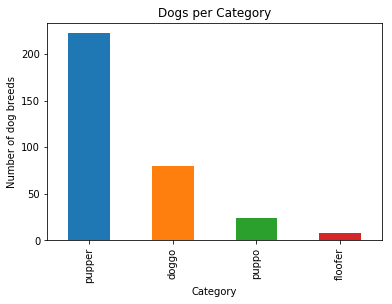

In [85]:
# How many dog breeds are there per category?
ax = df_twitter_archive_master.groupby(['dog_category'])['dog_breed'].count().sort_values(ascending=False).plot(kind='bar');
ax.set_title('Dogs per Category')
ax.set_xlabel('Category')
ax.set_ylabel('Number of dog breeds')

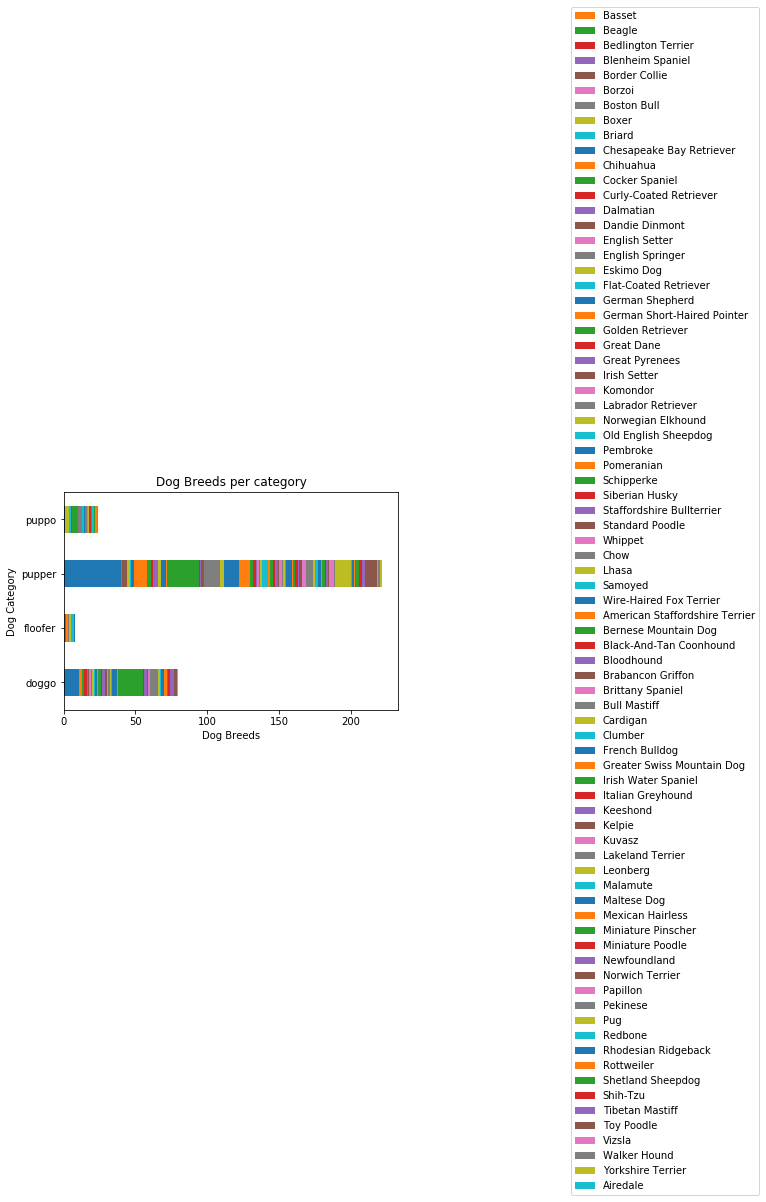

In [86]:
# Which dog breeds are in which category?
df_twitter_archive_master.groupby(['dog_category','dog_breed']).size().unstack().plot(kind='barh', stacked=True, title='Dog Breeds per category');
plt.legend(loc='center left', bbox_to_anchor=(1.5, 0.5));
plt.xlabel('Dog Breeds');
plt.ylabel('Dog Category');

We can see that the largest category consists of puppers, followed by doggos. Finally we have some puppos and floofers.

<a id='insight2'></a>
### Insight #2: What are the top 10 dog breeds that are the most favorite?¶
<a href="#insights">Back to Insights</a>

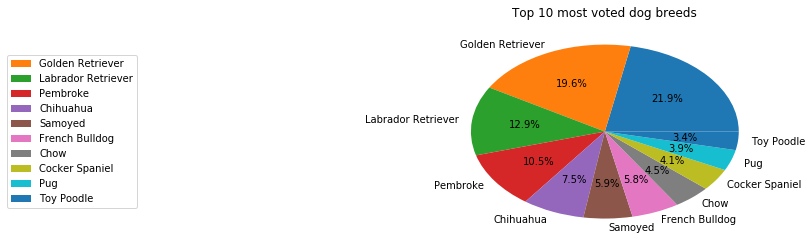

In [87]:
# Plot results
bx = df_twitter_archive_master.groupby(['dog_breed'])['favorite_count'].sum().sort_values(ascending=False).head(11).plot.pie(autopct='%1.1f%%', title='Top 10 most voted dog breeds');
plt.legend(loc='center left', bbox_to_anchor=(- 1.3, 0.5));
bx.set_ylabel('');

While the largest number of favorite votes (21.9%) do not have a dog breed registered, we can clearly identify the top 10 favorite dog breeds that have been voted for the most. The Golden Retriever has been the favorite dog that has been voted for the most with 19.6%, close to the number of all votes where the dog breed has not been registered, and the Labrador Retriever as second (12.9%).
> Note: As the highest favorite count is assigned to tweets that have no dog breed assigned, I have increased the selection to include 11 different dog breeds

<a id='insight3'></a>
### Insight #3: What are the top 10 dog breeds that rated, on average, the highest?
<a href="#insights">Back to Insights</a>

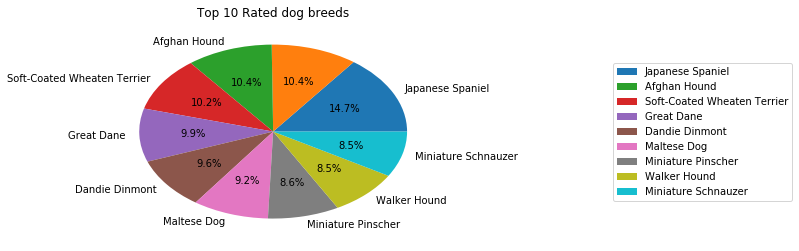

In [88]:
# Plot results
cx = df_twitter_archive_master.groupby(['dog_breed'])['rating'].mean().sort_values(ascending=False).head(10).plot(kind='pie', autopct='%1.1f%%', title='Top 10 Rated dog breeds');
plt.legend(loc='center left', bbox_to_anchor=(1.5, 0.5));
cx.set_ylabel('');

As we can see, the Japanese Spaniel, the Afghan Hound and the Soft-Coated Wheaten Terrier are, **on average**, the highest rated dog breeds. 

<a id='insight4'></a>
### Insight #4: Do the highest rated dog breeds also receive the most favorite or retweet counts?
<a href="#insights">Back to Insights</a>

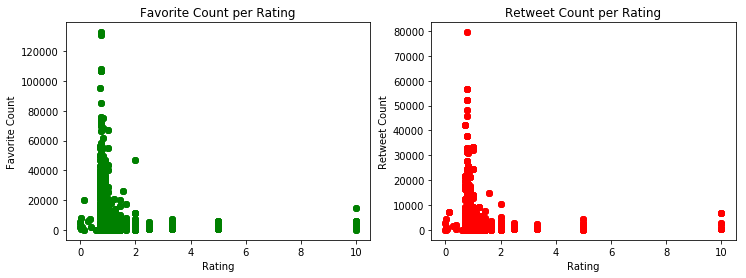

In [89]:
fig, axes = plt.subplots(1, 2, figsize = (12,4))
sb.regplot(x=df_twitter_archive_master['rating'], y=df_twitter_archive_master['favorite_count'], fit_reg=False, ax=axes[0], color='green');
sb.regplot(x=df_twitter_archive_master['rating'], y=df_twitter_archive_master['retweet_count'], fit_reg=False, ax=axes[1], color='red');
axes[0].set_title('Favorite Count per Rating');
axes[1].set_title('Retweet Count per Rating');
axes[0].set_xlabel('Rating');
axes[0].set_ylabel('Favorite Count');
axes[1].set_xlabel('Rating');
axes[1].set_ylabel('Retweet Count');

Based on the scatterplot, we can determine that the dog breeds who have received the highest ratings do not automatically have the most favorite or retweet counts.

#### Sources
https://www.delftstack.com/howto/python/python-except-exception-as-e/
https://stackoverflow.com/questions/23415500/pandas-plotting-a-stacked-bar-chart
https://github.com/mwaskom/seaborn/issues/1735